In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util import util

figsize = (20, 4.5)

# Loading data
data = util.load_data(data_folder='data', fnames=['train_FD004'])
dt_in = list(data.columns[3:-1])

# Regression Model

## Training and Test Set

**We want to use this data to train a RUL estimator**

We will use 75% of the experiments for training, 25% for testing

In [2]:
tr, ts = util.split_train_test_machines(data, tr_ratio=0.75, seed=42)
print(f'#Examples: {len(tr)} (traning), {len(ts)} (test)')
print(f'#Experiments: {len(tr["machine"].unique())} (traning), {len(ts["machine"].unique())} (test)')

#Examples: 45385 (traning), 15864 (test)
#Experiments: 186 (traning), 63 (test)


* We have more than enough data for training and for testing

**What if we didn't?**

Things would become _more complicated_, but there are a few options:

* Choose a less data-hungry approach
* Try to use lower-quality data (e.g. unsupervised data)
* Rely on external knowledge (empirical rules, physics...)

## Rescaling

**We will standardiza all input attributes and normalize the RUL**

In [3]:
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)
tr_s.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,45385.000000,45385.000000,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,...,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,45385.000000
mean,122.490955,133.323896,2.894775e-16,1.302570e-16,1.178889e-16,4.664830e-15,2.522791e-15,1.727041e-15,-6.633794e-16,1.496703e-16,...,1.135835e-15,-6.017186e-15,-1.409030e-16,-1.058182e-15,-6.532030e-16,1.583594e-16,-3.093135e-15,2.572263e-16,-1.477916e-16,0.244140
std,71.283034,89.568561,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.165256
min,1.000000,1.000000,-1.623164e+00,-1.838222e+00,-2.381839e+00,-1.055641e+00,-1.176507e+00,-1.646830e+00,-1.486984e+00,-1.138606e+00,...,-2.387561e+00,-2.583315e+00,-1.480340e+00,-6.950269e-01,-1.644539e+00,-2.151433e+00,-2.381839e+00,-1.077489e+00,-1.079308e+00,0.000000
25%,61.000000,62.000000,-9.461510e-01,-1.031405e+00,4.198344e-01,-1.055641e+00,-8.055879e-01,-6.341243e-01,-6.912917e-01,-1.138606e+00,...,4.181950e-01,-5.977256e-02,-8.501637e-01,-6.950269e-01,-6.379310e-01,-1.126840e-01,4.198344e-01,-9.979498e-01,-9.988926e-01,0.112546
50%,125.000000,123.000000,6.868497e-02,4.154560e-01,4.198344e-01,-3.917563e-01,-6.336530e-01,-4.718540e-01,-5.429267e-01,-2.714913e-01,...,4.194408e-01,1.862163e-01,-4.025983e-02,-6.950269e-01,-4.941298e-01,-3.717480e-02,4.198344e-01,-5.972306e-01,-5.971843e-01,0.225092
75%,179.000000,189.000000,1.218855e+00,8.661917e-01,4.198344e-01,6.926385e-01,7.407549e-01,7.495521e-01,8.439630e-01,6.867534e-01,...,4.202973e-01,7.086220e-01,1.055441e-01,1.438762e+00,7.641306e-01,6.561373e-01,4.198344e-01,7.740747e-01,7.744926e-01,0.346863
max,248.000000,543.000000,1.219524e+00,8.726308e-01,4.198344e-01,1.732749e+00,1.741030e+00,1.837978e+00,2.000975e+00,1.818973e+00,...,4.383623e-01,2.264997e+00,2.365107e+00,1.438762e+00,1.806689e+00,1.095464e+00,4.198344e-01,1.915822e+00,1.907272e+00,1.000000


## Building an MLP with Keras

**We will use the following function to build our model**

```python
def build_ml_model(input_size, output_size, hidden=[],
        output_activation='linear', name=None):
    ll = [keras.Input(input_size)]
    for h in hidden:
        ll.append(layers.Dense(h, activation='relu'))
    ll.append(layers.Dense(output_size, activation=output_activation))
    model = keras.Sequential(ll, name=name)
    return model
```

* The output activation function can be specified when calling the code
* We build the layers one by one (in a list)
* For each of them we specify the number of neurons and the activation function

**This is an alternative method to use the Keras sequential API**

## A Linear Regression Model for RUL Estimation

**We will start by building a Linear Regressor**

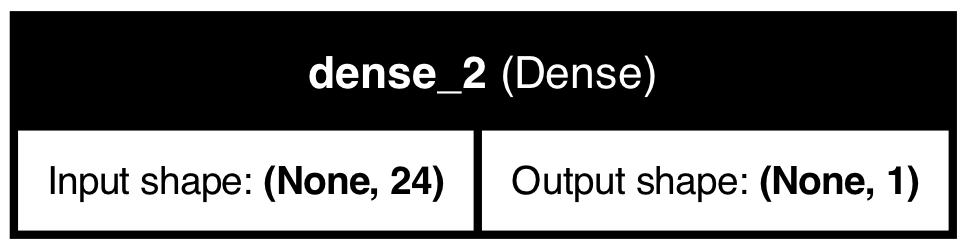

In [9]:
hidden = []
nn = util.build_ml_model(input_size=(len(dt_in),), output_size=1, hidden=hidden, output_activation='linear')
util.plot_ml_model(nn)

* The plot we obtain contains a few more details
* Since the `Sequential` object was able to process all layers in one go

## A Linear Regression Model for RUL Estimation

**Next, we trigger the training process**

We will use an early stoppping callback to prevent overfitting

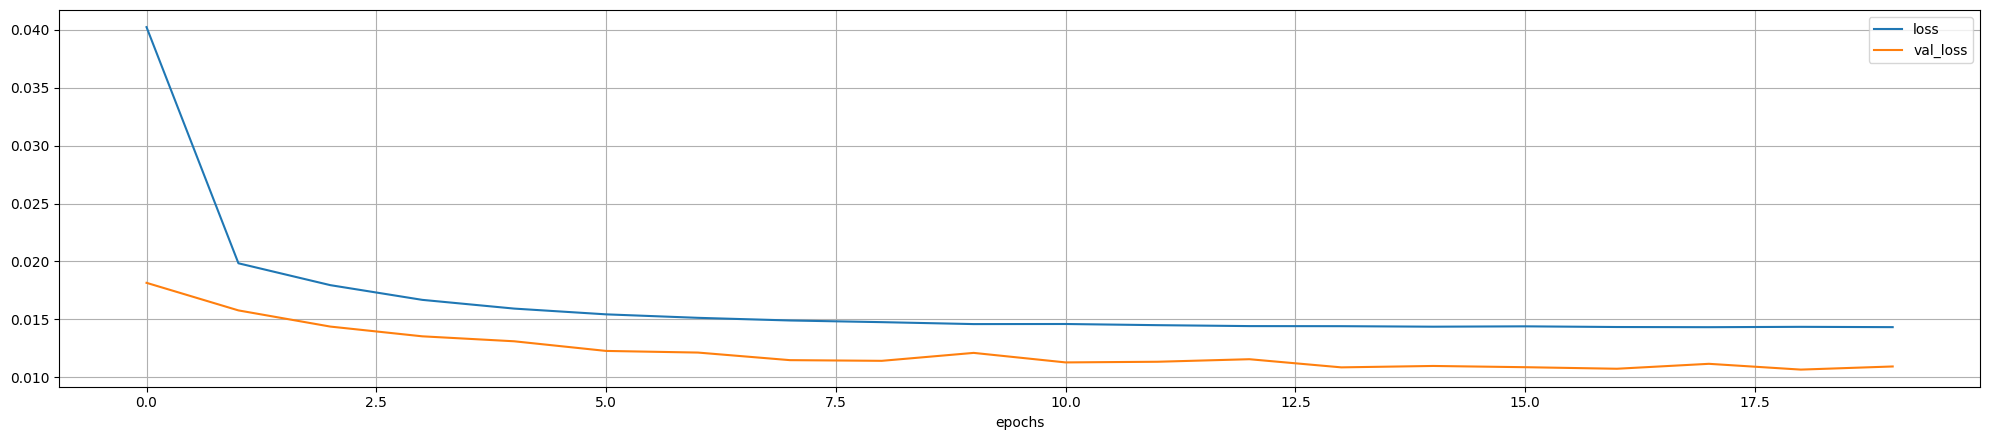

Final loss: 0.0143 (training), 0.0109 (validation)


In [10]:
history = util.train_ml_model(nn, tr_s[dt_in], tr_s['rul'], epochs=20, validation_split=0.2)
nn.save('lr_model.keras')
util.plot_training_history(history, figsize=figsize)

## An MLP for RUL Estimation

**Let's switch to a Neural Network with 2 hidden layers**

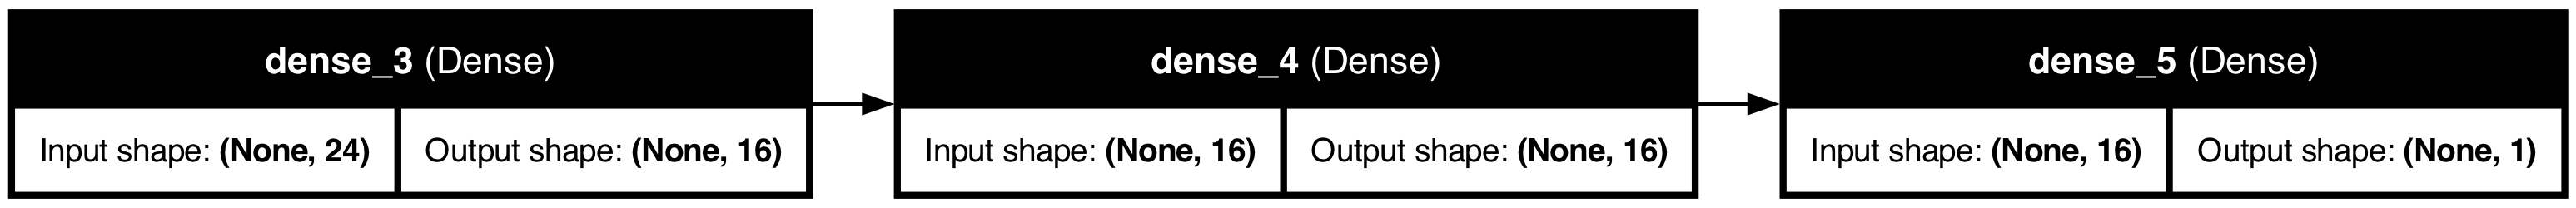

In [12]:
hidden = [16, 16]
nn2 = util.build_ml_model(input_size=(len(dt_in),), output_size=1, hidden=hidden, output_activation='linear')
util.plot_ml_model(nn2)

* Now we have two hidden layers with 16 neurons each
* The activation function for this is not displayed
* ...But we know we are using a ReLU

## An MLP for RUL Estimation

**Let's train this new model**

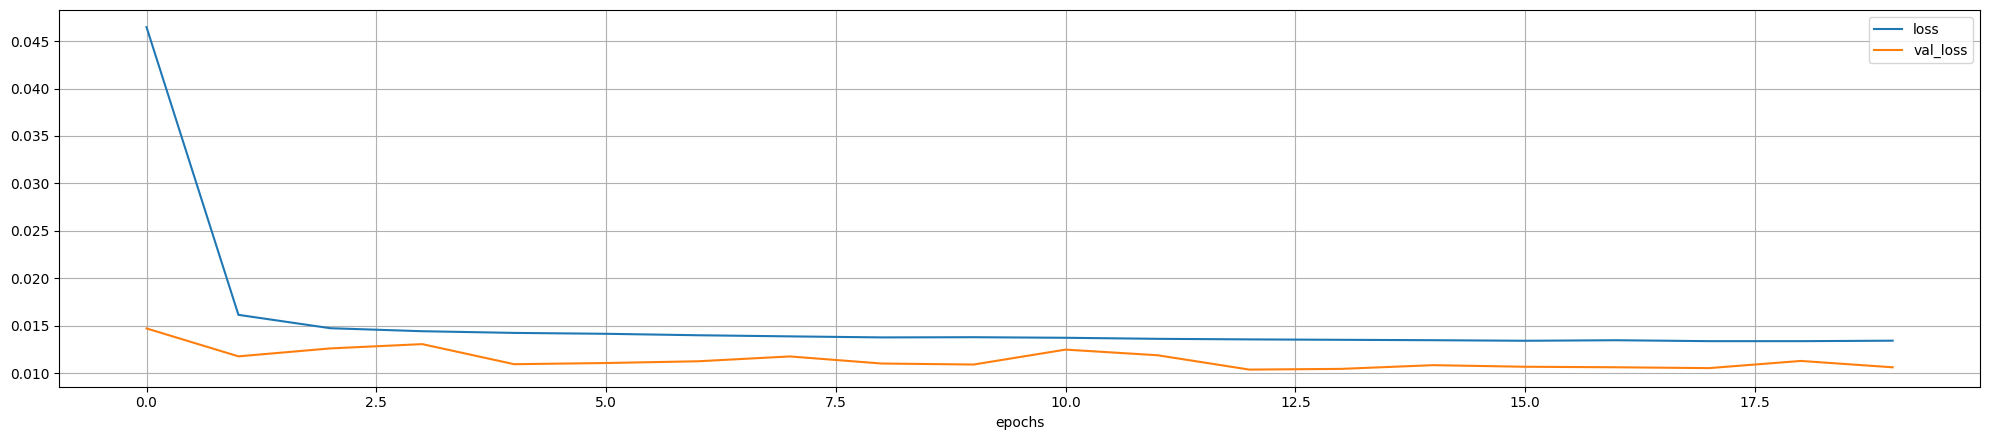

Final loss: 0.0134 (training), 0.0106 (validation)


In [13]:
history = util.train_ml_model(nn2, tr_s[dt_in], tr_s['rul'], epochs=20, validation_split=0.2)
nn2.save('mlp_model.keras')
util.plot_training_history(history, figsize=figsize)

We are doing better with this one (but only slighly)

## Evaluating Our Model

**Let's check the prediction quality for our model**

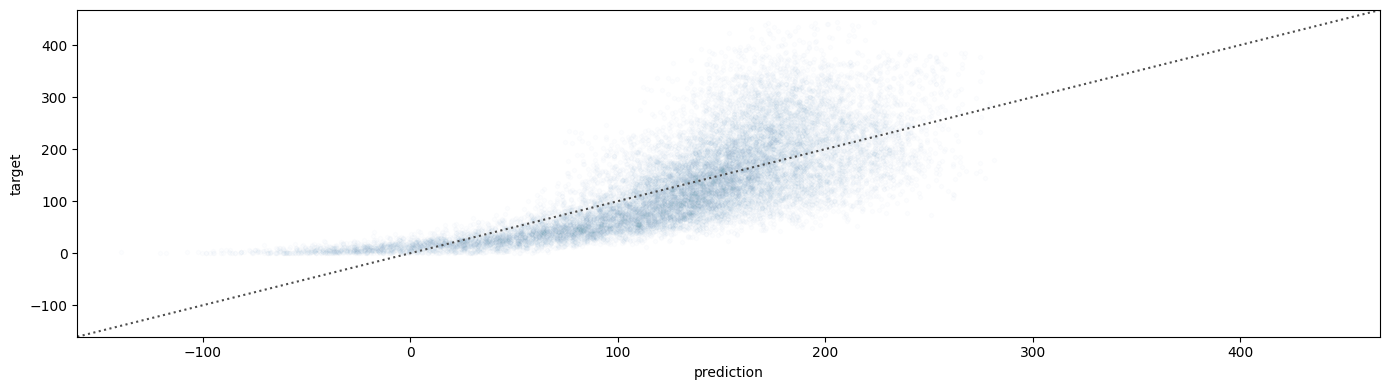

R2 score: 0.541


In [14]:
ts_pred = nn.predict(ts_s[dt_in], verbose=0).ravel() * nparams['trmaxrul']
util.plot_pred_scatter(ts_pred, ts['rul'], figsize=(14, 4))

The Linear Regression model does not seem to work very well

## Evaluating Regression Models

**Here are the results for the deeper network**

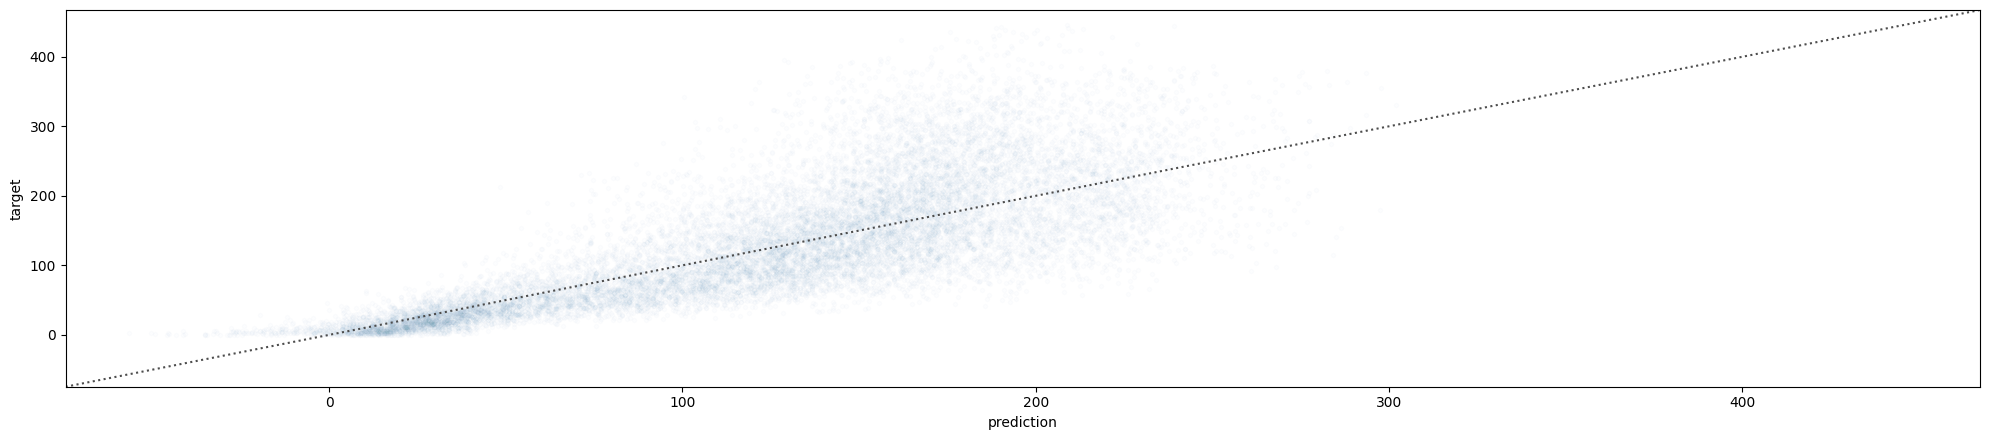

R2 score: 0.573


In [15]:
ts_pred = nn2.predict(ts_s[dt_in], verbose=0).ravel() * nparams['trmaxrul']
util.plot_pred_scatter(ts_pred, ts['rul'], figsize=figsize)

The deeper model does not work much better